In [ ]:
!pip install transformers==3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 754.6/754.6 KB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 KB 47.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 101.9 MB/s eta 0:00:00
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=36e26fc0784365a9a360aa31a2ce8489feaf662ce548c0265d3e643e852d87f0
  Stored in directory: /root/.cache/pip/wheels/82/ab/9b/c15899bf659ba74f623ac776e861cf2eb8608c1825ddec66a4
Successfully built sacremoses


In [ ]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
# Importing stock ml libraries
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split

import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
raw_data_path = "/content/drive/MyDrive/updated_resume_dataset_entities 2.csv"
# destination_folder = '/content/'

df_raw =  pd.read_csv(raw_data_path)
# df_raw = df_raw.head(1000)
df_raw.head()

,Text,Skills,Education,Experience,Additional_Information,Software_Developer,Front_End_Developer,Network_Administrator,Web_Developer,Project_manager,Database_Administrator,Security_Analyst,Systems_Administrator,Python_Developer,Java_Developer
0,Front End Developer Front End Developer Front ...,Java Angular Angularjs Javascript User Interfa...,B.S.,Front End Developer Carnes Trucking - Atlanta ...,SKILLS HTML Cascading Style Sheets CSS JavaScr...,1,1,0,0,0,0,0,0,0,0
1,Systems Engineer Systems Engineer Systems Engi...,DNS Can troubleshoot Vista Windows 7 and co...,NaN,Systems Engineer Shlemmer Algaze Associates - ...,MCSA / MCITP Windows Server 2008 / Server Admi...,0,0,0,0,0,0,0,1,0,0
2,Java Developer Java Developer Java Developer -...,HIBERNATE J2EE JSP JAVA ECLIPSE,Masters in Information Technology in Informati...,Java Developer Department of Labor - Washingto...,NaN,1,0,0,0,0,0,0,0,0,1
3,Telecommunications Technician Telecommunicatio...,Telecommunication Vlan TCP/IP (6 years) Avaya ...,Associate Specialized Tech in Information Tech...,Telecommunications Technician Telecom Business...,NaN,0,0,1,0,0,0,0,0,0,0
4,Full Stack Developer Full Stack Developer Full...,Java Git Jenkins Rest Version control Javascri...,NaN,Full Stack Developer CoreLogic - Irvine CA Oct...,Technical Skills Languages Java 1.8 J2EE Java...,1,0,0,0,0,0,0,0,0,1


In [ ]:
df_raw['Text'][0]

'Front End Developer Front End Developer Front End Developer - Carnes Trucking Heflin AL Work Experience Front End Developer Carnes Trucking - Atlanta GA September 2017 to Present Establish relationships by conferring with clients Diagnose internal IT issues and collaborate with engineers to develop and maintain internal Carnes Trucking user sites using front end technologies eg. HTML CSS Java AngularJS Python and JavaScript. Using Sublime to debug as well as implement changes within the Carnes intranet sites and also perform day to day operations within the Mcleod Loadmaster systems. IT Technician East Alabama Regional Medical Center - Anniston AL April 2014 to September 2017 Coordinated with a small team the maintenance of point of sale software and internal applications using front end technologies eg. HTML CSS Angular JS and Java. Diagnosed hardware issues and communicated any issues effectively. Maintained a dialogue between the I.T. Dept. and the nursing staff to quickly resolve 

In [ ]:
df_raw.shape

(29780, 15)

In [ ]:
df_raw.columns

Index(['Text', 'Skills', 'Education', 'Experience', 'Additional_Information',
       'Software_Developer', 'Front_End_Developer', 'Network_Administrator',
       'Web_Developer', 'Project_manager', 'Database_Administrator',
       'Security_Analyst', 'Systems_Administrator', 'Python_Developer',
       'Java_Developer'],
      dtype='object')

In [ ]:
df_raw['target_list'] = df_raw[['Software_Developer', 'Front_End_Developer',
       'Network_Administrator', 'Web_Developer', 'Project_manager',
       'Database_Administrator', 'Security_Analyst', 'Systems_Administrator',
       'Python_Developer', 'Java_Developer']].values.tolist()

In [ ]:
df = df_raw[['Software_Developer', 'Front_End_Developer',
       'Network_Administrator', 'Web_Developer', 'Project_manager',
       'Database_Administrator', 'Security_Analyst', 'Systems_Administrator',
       'Python_Developer', 'Java_Developer']]
df['target_list'] = df_raw[['Software_Developer', 'Front_End_Developer',
       'Network_Administrator', 'Web_Developer', 'Project_manager',
       'Database_Administrator', 'Security_Analyst', 'Systems_Administrator',
       'Python_Developer', 'Java_Developer']].values.tolist()
# df['Skills+Experience'] = df_raw['Roles_Skills']+df_raw['Experience']

<ipython-input-12-59c105097210>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target_list'] = df_raw[['Software_Developer', 'Front_End_Developer',


In [ ]:
# df['RolesSkills'] = [''.join(l) for l in df_raw['Roles_Skills']]
# df['RolesSkills'] = df_raw['Roles_Skills'].apply(eval).apply(' '.join)
# # df['RolesSkills'] = df_raw['Roles_Skills'].apply(lambda x: ''.join(x))
# df['Skills+Experience'] = df['RolesSkills']+" "+df_raw['Experience']
df['Experience']=df_raw['Experience']

<ipython-input-13-822395a39af6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Experience']=df_raw['Experience']


In [ ]:
df

,Software_Developer,Front_End_Developer,Network_Administrator,Web_Developer,Project_manager,Database_Administrator,Security_Analyst,Systems_Administrator,Python_Developer,Java_Developer,target_list,Experience
0,1,1,0,0,0,0,0,0,0,0,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0]",Front End Developer Carnes Trucking - Atlanta ...
1,0,0,0,0,0,0,0,1,0,0,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",Systems Engineer Shlemmer Algaze Associates - ...
2,1,0,0,0,0,0,0,0,0,1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 1]",Java Developer Department of Labor - Washingto...
3,0,0,1,0,0,0,0,0,0,0,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",Telecommunications Technician Telecom Business...
4,1,0,0,0,0,0,0,0,0,1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 1]",Full Stack Developer CoreLogic - Irvine CA Oct...
...,...,...,...,...,...,...,...,...,...,...,...,...
29775,0,0,1,0,0,0,0,0,0,0,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",NETWORK ADMINISTRATOR HIMALAYAN JEWELRY LLC 20...
29776,1,0,0,0,0,0,0,0,0,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",Manager Technology Specialist SAS USA LLC - In...
29777,1,0,0,0,0,0,0,0,0,1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 1]",Mule ESB Developer HMS July 2017 to Present Re...
29778,0,0,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",Technology Liaison Analyst MetLife - Tampa FL ...


In [ ]:
# df['WORD_COUNT'] = df['Experience'].apply(lambda x: len(x.split()))

In [ ]:
# df_raw.hist('WORD_COUNT', bins=30)

In [ ]:
df2 = df[['Experience', 'target_list']].copy()
df2.head()

,Experience,target_list
0,Front End Developer Carnes Trucking - Atlanta ...,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
1,Systems Engineer Shlemmer Algaze Associates - ...,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
2,Java Developer Department of Labor - Washingto...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
3,Telecommunications Technician Telecom Business...,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
4,Full Stack Developer CoreLogic - Irvine CA Oct...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 1]"


In [ ]:
# Sections of config
#from transformers import XLNetTokenizer, XLNetModel
from transformers import BertTokenizer, BertModel
# Defining some key variables that will be used later on in the training
MAX_LEN = 256
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
EPOCHS = 4
LEARNING_RATE = 1e-05
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

In [ ]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe['Experience']
        self.targets = self.data.target_list
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [ ]:
train_size = 0.8
train_dataset = df2.sample(frac=train_size,random_state=200)
valid_dataset = df2.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)


print("FULL Dataset: {}".format(df2.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(valid_dataset.shape))

training_set = CustomDataset(train_dataset, tokenizer, MAX_LEN)
validation_set = CustomDataset(valid_dataset, tokenizer, MAX_LEN)

FULL Dataset: (29780, 2)
TRAIN Dataset: (23824, 2)
TEST Dataset: (5956, 2)


In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
validation_loader = DataLoader(validation_set, **test_params)

In [ ]:
len(training_loader)

745

In [ ]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        #self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased')
        self.l1 = model = BertModel.from_pretrained("bert-base-cased")
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 10)
    
    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

model = BERTClass()
model.to(device)

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    

In [ ]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [ ]:
len(training_loader)

745

In [ ]:
def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch'], valid_loss_min.item()

In [ ]:
import shutil, sys   
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)
    # if it is a best model, min validation loss
    if is_best:
        best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)

In [ ]:
#to use as global variables
val_targets=[]
val_outputs=[] 

In [ ]:
def train_model(start_epochs,  n_epochs, valid_loss_min_input, 
                training_loader, validation_loader, model, 
                optimizer, checkpoint_path, best_model_path):
   
  # initialize tracker for minimum validation loss
  valid_loss_min = valid_loss_min_input 
   
 
  for epoch in range(start_epochs, n_epochs+1):
    train_loss = 0
    valid_loss = 0

    model.train()
    print('############# Epoch {}: Training Start   #############'.format(epoch))
    for batch_idx, data in enumerate(training_loader):
        #print('yyy epoch', batch_idx)
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        #if batch_idx%5000==0:
         #   print(f'Epoch: {epoch}, Training Loss:  {loss.item()}')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print('before loss data in training', loss.item(), train_loss)
        train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.item() - train_loss))
        #print('after loss data in training', loss.item(), train_loss)
    
    print('############# Epoch {}: Training End     #############'.format(epoch))
    
    print('############# Epoch {}: Validation Start   #############'.format(epoch))
    ######################    
    # validate the model #
    ######################
 
    model.eval()
   
    with torch.no_grad():
      for batch_idx, data in enumerate(validation_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.item() - valid_loss))
            val_targets.extend(targets.cpu().detach().numpy().tolist())
            val_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

      print('############# Epoch {}: Validation End     #############'.format(epoch))
      # calculate average losses
      #print('before cal avg train loss', train_loss)
      train_loss = train_loss/len(training_loader)
      valid_loss = valid_loss/len(validation_loader)
      # print training/validation statistics 
      print('Epoch: {} \tAvgerage Training Loss: {:.6f} \tAverage Validation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
      
      # create checkpoint variable and add important data
      checkpoint = {
            'epoch': epoch + 1,
            'valid_loss_min': valid_loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
      }
        
        # save checkpoint
      save_ckp(checkpoint, False, checkpoint_path, best_model_path)
        
      ## TODO: save the model if validation loss has decreased
      if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
        # save checkpoint as best model
        save_ckp(checkpoint, True, checkpoint_path, best_model_path)
        valid_loss_min = valid_loss

    print('############# Epoch {}  Done   #############\n'.format(epoch))


  return model

In [ ]:
checkpoint_path = '/content/drive/MyDrive/resume_corpus-master/current_checkpoint.pt'
best_model = '/content/drive/MyDrive/resume_corpus-master/best_model.pt'
trained_model = train_model(1, 4, np.Inf, training_loader, validation_loader, model, optimizer,checkpoint_path,best_model)

############# Epoch 1: Training Start   #############
############# Epoch 1: Training End     #############
############# Epoch 1: Validation Start   #############
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 0.000393 	Average Validation Loss: 0.001105
Validation loss decreased (inf --> 0.001105).  Saving model ...
############# Epoch 1  Done   #############

############# Epoch 2: Training Start   #############
############# Epoch 2: Training End     #############
############# Epoch 2: Validation Start   #############
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 0.000271 	Average Validation Loss: 0.001001
Validation loss decreased (0.001105 --> 0.001001).  Saving model ...
############# Epoch 2  Done   #############

############# Epoch 3: Training Start   #############
############# Epoch 3: Training End     #############
############# Epoch 3: Validation Start   #############
############# Epo

In [ ]:
val_preds = (np.array(val_outputs) > 0.5).astype(int)
val_preds

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [ ]:
accuracy = metrics.accuracy_score(val_targets, val_preds)
f1_score_micro = metrics.f1_score(val_targets, val_preds, average='micro')
f1_score_macro = metrics.f1_score(val_targets, val_preds, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.55066319677636
F1 Score (Micro) = 0.7965263157894736
F1 Score (Macro) = 0.7677095021524601


In [ ]:
from sklearn.metrics import multilabel_confusion_matrix as mcm, classification_report

In [ ]:
cm_labels = ['Software_Developer', 'Front_End_Developer',
       'Network_Administrator', 'Web_Developer', 'Project_manager',
       'Database_Administrator', 'Security_Analyst', 'Systems_Administrator',
       'Python_Developer', 'Java_Developer']
    
cm = mcm(val_targets, val_preds)

In [ ]:
print(classification_report(val_targets, val_preds))

              precision    recall  f1-score   support

           0       0.94      0.91      0.92     11984
           1       0.89      0.69      0.78      3208
           2       0.88      0.52      0.65      3644
           3       0.78      0.59      0.67      5352
           4       0.87      0.67      0.76      3512
           5       0.95      0.65      0.78      2588
           6       0.89      0.68      0.77      2368
           7       0.91      0.62      0.74      4836
           8       0.92      0.77      0.84      2184
           9       0.88      0.69      0.78      2544

   micro avg       0.90      0.72      0.80     42220
   macro avg       0.89      0.68      0.77     42220
weighted avg       0.89      0.72      0.79     42220
 samples avg       0.83      0.73      0.76     42220



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    axes.set_xlabel('True label')
    axes.set_ylabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

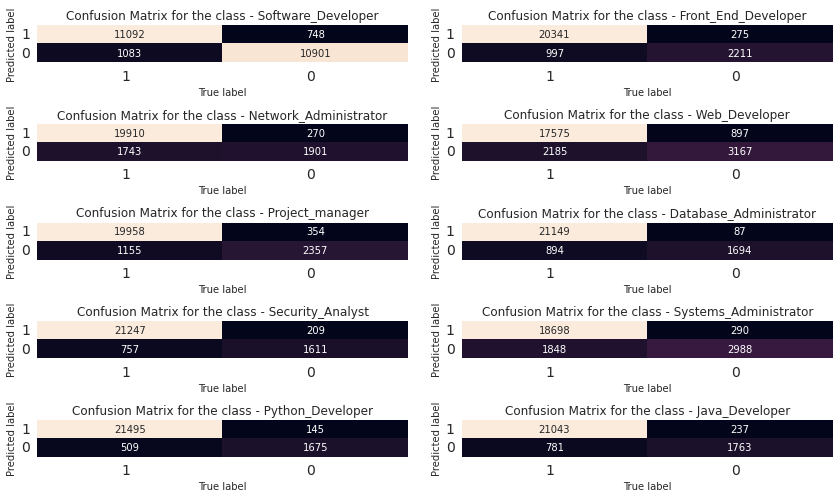

In [ ]:
#print_confusion_matrix(mcm(targets, val_preds),class_label=labels, class_names=labels)
sns.set_style("whitegrid")
fig, ax = plt.subplots(5, 2, figsize=(12, 7))
for axes, cfs_matrix, label in zip(ax.flatten(), cm, cm_labels):
  print_confusion_matrix(cfs_matrix, axes, label, ["1", "0"])
    
fig.tight_layout()
plt.show()